In [151]:
import numpy as np
import pandas as pd
import re, string, nltk, torch
from nltk.tokenize import word_tokenize
import words_repeated_char
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn

In [72]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
def read_csv(file_path, delimiter = ' '):
    """ We had some issues loading the data using pandas.read_csv, so we built our own loader.
        Read a csv file, returns a pandas.Dataframe
    """
    fp = open(file_path)
    line = fp.readline()
    data_dict = dict()
    labels = line[:-1].split(delimiter)
    line = fp.readline()
    for label in labels:
        data_dict[label] = []
    while line:
        for i, j in enumerate(line[:-1].split(delimiter)):
            data_dict[labels[i]].append(j)
        line = fp.readline()
    return pd.DataFrame(data_dict)

In [10]:
data = read_csv("data/hydrated/hateful_tweets_filtered.csv", delimiter='\t')

In [11]:
data.head()

,tweet_id,label,tweet_content
0,7629505483,abusive,I fuckin hate when niggas stare at me fuck r u...
1,12181574836,abusive,everyone jumps to silly conclusions as soon as...
2,25381445793,abusive,#sincewerebeinghonest I'm Emo. I Need A Fuckin...
3,192730077165916160,abusive,banana bread recipe: 1. get some bread 2. i do...
4,280882735374028800,abusive,godamn this bitch so bad i want 2 drink molly ...


In [76]:
lemmatizer = WordNetLemmatizer() 
preprocessed = []
count_words = Counter()
for i, tweet in enumerate(data["tweet_content"].values[:]):
    tmp = tweet.lower().replace("\\n",' ').replace('\\xa0', ' ').replace('\\r', ' ').replace("\\'","'").replace("&lt;",'<')\
         .replace("&gt;",'>').replace(" &amp; ", " and ").replace("&amp;", "&")
    # lower the tweet and replacing characters that tweeter has tranlated to their hmtl numeric code to their original value
    tmp = re.sub("(http(s)?://)?(www\.)?([a-zA-Z0-9])+\.[a-z]{1,3}(/\S*)?",'URL', tmp) # 
    tmp = re.sub("#\w+", 'HASHTAG', tmp)
    tmp = re.sub("@\w+", 'USER', tmp)
    tmp = re.sub("\w+@\w+\.[a-z]{2,3}", "EMAIL", tmp)
    tmp = re.sub("[0-9]{1,2}/[0-9]{1,2}/([0-9]{4}|[0-9]{2})|([0-9]{4}|[0-9]{2})/[0-9]{1,2}/[0-9]{1,2}|[0-9]{2}/[0-9]{2}", "DATE", tmp)
    tmp = re.sub("[0-9]{2}(:[0-9]{2}){1,2}( ?(am|pm))?", "TIME", tmp)
    tmp = re.sub("(([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF]))+", ' EMOJI ', tmp)
    tmp = tmp.encode(encoding='ascii', errors='ignore').decode()
    # get rid of the non ascii characters
    tmp = re.sub("\.{2,}", "...", tmp)
    for c in ['!', '-', ',']:
        tmp = re.sub("{}+".format(c), c, tmp)
    tmp = re.sub("\?+", "?", tmp)
    tmp = re.sub("`+", "'", tmp)
    tmp = re.sub("'{2,}", "'", tmp)
    tmp = tmp.translate(str.maketrans(dict.fromkeys('#*+/<=>@[\\]^_`{|}~'))) #removing all the other special characters
    tokens = [t if t not in ["''", "``"] else '"' for t in word_tokenize(tmp) ]
    # tokenizing using nltk.word_tokenize. althought it transforms '"' into '``' or "''" and this is a behaviour do not want
    # so we make sure that the '"' are changed to their original form
    vec = []
    for i, token in enumerate(tokens):
        if re.search(r"([a-z])\1{2,}", token):
            # cleaning the words containing a letter repeated 3 times or more, using the list of the Ensglish words
            tokens[i] = words_repeated_char.clean(token)
        tokens[i] = lemmatizer.lemmatize(tokens[i])
        count_words[tokens[i]] += 1
    preprocessed.append(tokens)

In [178]:
vocab_max = 50000
seq_length = 30
vocab = {w for w,_ in count_words.most_common(vocab_max-2)}.union( {"UNK", "PAD"})
word2val = {w : i+2 for i, (w,_) in enumerate( count_words.most_common(vocab_max-2) )}
word2val["PAD"] = 0
word2val["UNK"] = 1
X = []
for tweet in preprocessed:
    tmp = [word2val[tok] if tok in vocab else word2val["UNK"] for tok in tweet]
    if len(tmp) > seq_length:
        X.append(tmp[:seq_length])
    else:
        X.append([0 for _ in range(seq_length - len(tmp))] + tmp)
X = np.array(X)

In [179]:
le = LabelEncoder()
y = le.fit_transform(data["label"].values)

Text(0.5, 1.0, 'Sequence length distribution')

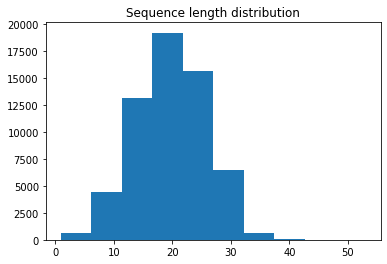

In [51]:
plt.hist([len(x) for x in X])
plt.title("Sequence length distribution")

In [181]:
 X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train).to(device)
X_valid = torch.tensor(X_valid).to(device)
X_test = torch.tensor(X_test).to(device)
y_train = torch.tensor(y_train).to(device)
y_valid = torch.tensor(y_valid).to(device)
y_test = torch.tensor(y_test).to(device)

In [160]:
class RNN(nn.Module):
    def __init__(self,
                 emb_size,
                 hidden_size,
                 vocab_size,
                 n_layers,
                 output_size,
                 p_dropout
                ):
        super(RNN, self).__init__()
        #hyper-parameters
        self.emb_size    = emb_size
        self.hidden_size = hidden_size
        self.vocab_size  = vocab_size
        self.n_layers    = n_layers
        self.emb_size    = emb_size
        self.output_size = output_size
        #layers
        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)
        self.layers = dict()
        self.layers["do0"] = nn.Dropout(p=p_dropout)
        self.layers["h1"] = nn.Linear(emb_size+hidden_size, hidden_size).to(device)
        self.layers["do1"] = nn.Dropout(p=p_dropout)
        for layer in range(2, n_layers+1):
            self.layers[f"h{layer}"] = nn.Linear(2*hidden_size, hidden_size).to(device)
            self.layers[f"do{layer}"] = nn.Dropout(p=p_dropout)
        self.output_layer = nn.Linear(hidden_size, output_size)
        #init weights
        self.init_weight()
        
    def init_weight(self):
        nn.init.xavier_normal_(self.output_layer.weight)
        for layer in range(2, self.n_layers+1):
            nn.init.xavier_normal_(self.layers[f"h{layer}"].weight)
    def forward(self, X):
        out = self.embedding(X)
        out = self.layers["do0"](out)
#         for layer in range(1, self.n_layers+1):
#             out = self.layers[f"h{layer}"](out)
#             out = self.layers[f"do{layer}"](out)
        

In [162]:
a = RNN(1000, 1000, vocab_size, 2, 4, 0.5)

In [182]:
a.forward(X_train[:10])

torch.Size([10, 30])
torch.Size([10, 30, 1000])
